# Libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

<ipython-input-1-7671890414ce>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


# 1-Dimension
---

## Cell

## Initial condition contain , distribution of $\rho$, $\rho v$ and $\rho S$
Initial state variable $(\rho, \rho v, \rho S)$. Now based on this calculate your p vector

In [ ]:
class Cell:
    def __init__(self):
        self.u = np.array([[0.0, 0.0, 0.0]] * (Config.NUM_RK_STEPS + 1)) # update in terms of rho, rho u and E
              # MAke changes in flux accordingly

        # self.q = np.array([[0.0, 0.0, 0.0]] * (Config.NUM_RK_STEPS + 1)) # rho, v & p    #rho, rho v, rho S.
        self.uwest = np.array([0.0, 0.0, 0.0])
        self.uEast = np.array([0.0, 0.0, 0.0])
        self.cx = 0.0
        self.dx = 0.0
        self.totalFlux = np.array([0.0, 0.0, 0.0])

## Ghost Cells

In [ ]:
class GhostCellUpdater:
    @staticmethod
    def updateGhostCells(cells, rkStep):
        for ghostCell in range(Config.NUM_GHOST_CELLS):
          cells[ghostCell].u[rkStep] = cells[Config.NUM_X_CELLS + ghostCell].u[rkStep]
          cells[Config.NUM_X_CELLS + Config.NUM_GHOST_CELLS + ghostCell].u[rkStep] = cells[Config.NUM_GHOST_CELLS + ghostCell].u[rkStep]

## Reconstruction Types

In [ ]:
from enum import Enum

class ReconstructionTypes(Enum):
    FIRST_ORDER = 1
    LAX_WENDROFF = 2
    BEAM_WARMING = 3
    FROMM = 4
    LIMITED_LM = 5

## Config

In [ ]:
class Config:
    NUM_X_CELLS = 100
    # NUM_X_CELLS = 100
    NUM_GHOST_CELLS = 3
    NUM_RK_STEPS = 1       # Can be 1,2,3
    STOPPING_TIME = 0.01
    MAX_TIME_ITER = 1000
    MIN_X = 0.0            # -1.0
    MAX_X = 1.0
    ADVECTION_VEL = 1.0
    COURANT_NUM = 0.1
    RECONST_TYPE = ReconstructionTypes.LIMITED_LM
    gamma = 1.4

## Reconstruct Variables

In [ ]:
class VariableReconstructor:
    @staticmethod
    def reconstructVariables(cells, rkStep):
        reconst_type = Config.RECONST_TYPE

        if reconst_type == ReconstructionTypes.FIRST_ORDER:
            for i in range(Config.NUM_GHOST_CELLS - 1, Config.NUM_X_CELLS + Config.NUM_GHOST_CELLS + 1):
                cells[i].uWest = cells[i].u[rkStep]
                cells[i].uEast = cells[i].u[rkStep]

        elif reconst_type == ReconstructionTypes.BEAM_WARMING:
            for i in range(Config.NUM_GHOST_CELLS - 1, Config.NUM_X_CELLS + Config.NUM_GHOST_CELLS + 1):
                du_dx = (cells[i].u[rkStep] - cells[i - 1].u[rkStep]) / cells[i].dx
                cells[i].uWest = cells[i].u[rkStep] - du_dx * cells[i].dx / 2.0
                cells[i].uEast = cells[i].u[rkStep] + du_dx * cells[i].dx / 2.0

        elif reconst_type == ReconstructionTypes.LAX_WENDROFF:
            for i in range(Config.NUM_GHOST_CELLS - 1, Config.NUM_X_CELLS + Config.NUM_GHOST_CELLS + 1):
                du_dx = (cells[i+1].u[rkStep] - cells[i].u[rkStep]) / cells[i].dx
                cells[i].uWest = cells[i].u[rkStep] - du_dx * cells[i].dx / 2.0
                cells[i].uEast = cells[i].u[rkStep] + du_dx * cells[i].dx / 2.0

        elif reconst_type == ReconstructionTypes.FROMM:
            for i in range(Config.NUM_GHOST_CELLS - 1, Config.NUM_X_CELLS + Config.NUM_GHOST_CELLS + 1):
                du_dx = (cells[i+1].u[rkStep] - cells[i-1].u[rkStep]) / 2.0 / cells[i].dx
                cells[i].uWest = cells[i].u[rkStep] - du_dx * cells[i].dx / 2.0
                cells[i].uEast = cells[i].u[rkStep] + du_dx * cells[i].dx / 2.0

        elif reconst_type == ReconstructionTypes.LIMITED_LM:
            for i in range(Config.NUM_GHOST_CELLS - 1, Config.NUM_X_CELLS + Config.NUM_GHOST_CELLS + 1):
                r = (cells[i].u[rkStep] - cells[i-1].u[rkStep]) / (cells[i+1].u[rkStep] - cells[i].u[rkStep] + 0.000001)
                r = max(0, r.max())

                phi = (r*r + r) / (r*r + 1) # Alba Limiter
                du_dx = (cells[i+1].u[rkStep] - cells[i].u[rkStep]) / cells[i].dx
                cells[i].uWest = cells[i].u[rkStep] - phi * du_dx * cells[i].dx / 2.0
                cells[i].uEast = cells[i].u[rkStep] + phi * du_dx * cells[i].dx / 2.0

## Variable Copier

In [ ]:
class VariableCopier:
    def CopyToZerothRKStep(cells):
        for i in range(Config.NUM_GHOST_CELLS,Config.NUM_X_CELLS+Config.NUM_GHOST_CELLS,1):
            cells[i].u[0] = cells[i].u[Config.NUM_RK_STEPS]

## Time Step Calculator

In [ ]:
e_ref = 1.0
Cv = 1/(Config.gamma - 1)

def calculatePressure(cell):
    rho = cell.u[0][0]
    u = cell.u[0][1] / rho
    S = cell.u[0][2] / rho
    # e = e_ref * np.exp(S / Cv)
    # return (Config.gamma-1) * rho * (e- 0.5 * u**2)
    return (rho ** Config.gamma) * np.exp(S/Cv)

In [ ]:
# def calculatePressure(cell):
#   return np.exp(cell.u[0][2]/cell.u[0][0]) * (cell.u[0][0]**Config.gamma)
class TimeStepCalculator:
    @staticmethod
    def getTimeStep(cells):
        # Assuming dx is constant for all cells
        for cell in cells:
            cell.u = np.nan_to_num(cell.u, copy=True, nan=1e-5, posinf=None, neginf=None)
        press = [calculatePressure(cell) for cell in cells]
        press = np.array([v if v <1e10 else 0 for v in press])
        rho = np.array([cell.u[0][0] for cell in cells])
        # assert(rho.min() > 0)
        # print(Config.gamma * press/(rho + 1e-5))
        soundSpeed = np.sqrt(Config.gamma * press/(rho + 1e-5))
        soundSpeed = np.nan_to_num(soundSpeed, copy = True, nan = 10)
        v = [0 if cell.u[0][0] > 1e3 else cell.u[0][1]/cell.u[0][0] for cell in cells]
        v = np.array([v if np.abs(v) < 1e-5 else 0 for v in v])
        return [Config.COURANT_NUM * cells[0].dx * ((np.abs(v) + soundSpeed).max()), (np.abs(v) + soundSpeed).max()]

## Time Integration

In [ ]:
class TimeIntegration:
    @staticmethod
    def updateCellAverage(cells, rkStep, dt):
        if(Config.NUM_RK_STEPS == 1):
            for i in range(Config.NUM_GHOST_CELLS, Config.NUM_X_CELLS+Config.NUM_GHOST_CELLS,1):
                cells[i].u[rkStep+1] = cells[i].u[rkStep] + dt / cells[i].dx * cells[i].totalFlux

        elif(Config.NUM_RK_STEPS == 2):
            for i in range(Config.NUM_GHOST_CELLS, Config.NUM_X_CELLS+Config.NUM_GHOST_CELLS,1):
                if(rkStep == 0):
                    cells[i].u[rkStep+1] = cells[i].u[rkStep] + dt / cells[i].dx * cells[i].totalFlux
                elif(rkStep == 1):
                    cells[i].u[rkStep+1] = 0.5 * {cells[i].u[rkStep-1] + cells[i].u[rkStep] + dt/cells[i].dx * cells[i].totalFlux}

        elif(Config.NUM_RK_STEPS == 3):
            for i in range(Config.NUM_GHOST_CELLS, Config.NUM_X_CELLS+Config.NUM_GHOST_CELLS,1):
                if(rkStep == 0):
                    cells[i].u[rkStep+1] = cells[i].u[rkStep] + dt / cells[i].dx * cells[i].totalFlux
                elif(rkStep == 1):
                    cells[i].u[rkStep+1] = 0.75 * cells[i].u[rkStep-1] + 0.25 * cells[i].u[rkStep] + 0.25 * dt/cells[i].dx * cells[i].totalFlux
                elif(rkStep == 2):
                    cells[i].u[rkStep+1] = 0.33 * cells[i].u[rkStep-2] + 0.67 * cells[i].u[rkStep] + 0.67 * dt/cells[i].dx * cells[i].totalFlux

## Flux


In [ ]:
def calculateEnergy(cells, index, rkStep):
    m1 = cells[index].u[rkStep][0]
    m2 = cells[index].u[rkStep][1]
    m3 = cells[index].u[rkStep][2]

    energy = 0
    if(not(math.isnan(m2*m2/m1))):
        energy += m2*m2/m1

    if(not(math.isnan(np.exp(m3/m1))) and
       not(math.isnan(m1**Config.gamma-1)) and
       not(math.isnan(np.exp(m3/m1) * (m1**Config.gamma-1)))):
        energy += math.isnan(np.exp(m3/m1) * (m1**Config.gamma-1))

    return energy

In [ ]:
class Flux:
    @staticmethod
    def calculateFlux(cells, rkStep):
        for i in range(len(cells)):
            cells[i].totalFlux = [0.0, 0.0, 0.0]

        for interfaceIndex in range(Config.NUM_GHOST_CELLS, Config.NUM_GHOST_CELLS+Config.NUM_X_CELLS+1, 1):

            # ================================================================== #  Using the given condition taking q = (rho, rho v, rho S)
            #Left Values
            left_m1 = cells[interfaceIndex-1].uEast[0]  # cells[interfaceIndex-1].u[rkStep][0]
            left_m2 = cells[interfaceIndex-1].uEast[1]  # cells[interfaceIndex-1].u[rkStep][1]
            left_m3 = cells[interfaceIndex-1].uEast[2]  # cells[interfaceIndex-1].u[rkStep][2]

            left_c1, left_c2, left_c3 = left_m2, 0.0, 0.0
            left_v, left_p = 0.0, calculatePressure(cells[interfaceIndex-1]) # 0.0

            if(not(math.isnan(left_m2/left_m1))):
                left_v = left_m2/left_m1

            left_e1 = 0.5 * left_m1 * (left_v ** 2)
            # left_p = (Config.gamma-1)*(cells[interfaceIndex-1].u[rkStep][2] - left_e1)


            # # Right Values
            right_m1 = cells[interfaceIndex].uWest[0] # cells[interfaceIndex].u[rkStep][0]
            right_m2 = cells[interfaceIndex].uWest[1] # cells[interfaceIndex].u[rkStep][1]
            right_m3 = cells[interfaceIndex].uWest[2] # cells[interfaceIndex].u[rkStep][2]

            right_c1, right_c2, right_c3 = right_m2, 0.0, 0.0
            right_v, right_p = 0.0, calculatePressure(cells[interfaceIndex]) #0.0

            if(not(math.isnan(right_m2/right_m1))):
                right_v = right_m2/right_m1

            right_e1 = 0.5 * right_m1 * (right_v ** 2)
            # right_p = (Config.gamma-1)*(cells[interfaceIndex].u[rkStep][2] - left_e1)



            # Flux according to lax schemᡕぃ/ᡕe
            # flux = 0.5 * Config.ADVECTION_VEL * (leftValue + rightValue) #- 0.5 * abs(Config.ADVECTION_VEL) * (rightValue - leftValue)

            # ================================================================== #
            # Updating the left values
            # if(not(math.isnan((left_m2 / left_m1) ** Config.gamma) and not(math.isnan(np.exp(left_m3/left_m1))))):
                # left_c2 += ((left_m2 / left_m1) ** Config.gamma + np.exp((left_m3/left_m1)))
                # left_p += ((left_m2 / left_m1) ** Config.gamma + np.exp((left_m3/left_m1)))

            left_c2 += left_p
            if(not(math.isnan((left_m2 ** 2) / left_m1))):
                left_c2 += ((left_m2 ** 2) / left_m1)

            if(not(math.isnan(left_m2 * left_m3 / left_m1))):
                left_c3 += (left_m2 * left_m3 / left_m1)
            leftValue = np.array([left_c1, left_c2, left_c3])


            # Updating the right values
            # if(not(math.isnan((right_m2 / right_m1) ** Config.gamma)) and not(math.isnan(np.exp(right_m3/right_m1)))):
                # right_c2 += ((right_m2 / right_m1) ** Config.gamma + np.exp((right_m3/right_m1)))
                # right_p += ((right_m2 / right_m1) ** Config.gamma + np.exp((right_m3/right_m1)))

            right_c2 += right_p
            if(not(math.isnan((right_m2 ** 2) / right_m1))):
                right_c2 += ((right_m2 ** 2) / right_m1)

            if(not(math.isnan(right_m2 * right_m3 / right_m1))):
                right_c3 += (right_m2 * right_m3 / right_m1)
            rightValue = np.array([right_c1, right_c2, right_c3])

            # Now, update the flux by taking the average of the left and the right values. Schu-Osher Flux Updation

            flux = 0.5 * (leftValue + rightValue)

            # ================================================================== #
            # ALPHA: The Correction Term (Involves p vector and dot product)

            alpha = 0.0

            # p-vector -> Left Side
            left_mul_term, left_p1, left_p2, left_p3 = 0.0, 0.0, 0.0, 0.0
            if(not(math.isnan(np.exp(left_m3/left_m1)))
            and not(math.isnan(left_m1 ** (Config.gamma-1)))
            and not(math.isnan(np.exp(left_m3/left_m1) * (left_m1 ** (Config.gamma-1))))):
                left_mul_term += np.exp(left_m3/left_m1) * (left_m1 ** (Config.gamma-1))
                left_p3 += left_mul_term

            if(left_mul_term != 0):
                left_p1 += Config.gamma * left_mul_term
                if(not(math.isnan(left_m3/left_m1))):
                    left_p1 -= left_mul_term * left_m3/left_m1

            if(not(math.isnan((left_m2**2)/left_m1))):
                left_p1 -= 0.5 * (left_m2**2)/left_m1

            left_vec_p = np.array([left_p1, left_p2, left_p3])

            # p-vector -> Left Side
            right_mul_term, right_p1, right_p2, right_p3 = 0.0, 0.0, 0.0, 0.0
            if(not(math.isnan(np.exp(right_m3/right_m1)))
            and not(math.isnan(right_m1 ** (Config.gamma-1)))
            and not(math.isnan(np.exp(right_m3/right_m1) * (right_m1 ** (Config.gamma-1))))):
                right_mul_term += np.exp(right_m3/right_m1) * (right_m1 ** (Config.gamma-1))
                right_p3 += right_mul_term

            if(right_mul_term != 0):
                right_p1 += Config.gamma * right_mul_term
                if(not(math.isnan(right_m3/right_m1))):
                    right_p1 -= right_mul_term * right_m3/right_m1

            if(not(math.isnan((right_m2**2)/right_m1))):
                right_p1 -= 0.5 * (right_m2**2)/right_m1

            right_vec_p = np.array([right_p1, right_p2, right_p3])

            # Difference vector of the right and the left p-vector values
            diff_vec = right_vec_p - left_vec_p

            if(np.dot(diff_vec, diff_vec) > 1e-3):
                left_F12 = left_v * (left_e1 + (2 * Config.gamma - 1) / (Config.gamma - 1) * left_p)
                right_F12 = right_v * (right_e1 + (2 * Config.gamma - 1) / (Config.gamma - 1) * right_p)

                alpha = right_F12 - left_F12 + np.dot(flux, diff_vec)- (np.dot(right_vec_p, rightValue) - np.dot(left_vec_p, leftValue))
                alpha = alpha / np.dot(diff_vec, diff_vec)
                # flux = flux - alpha * diff_vec

            # ================================================================== #
            # Epsilon: The Dissipation Term

            # E values for previous to previous to Left, Left, Right, next to Right
            left_prev_E = calculateEnergy(cells, interfaceIndex-2, rkStep)
            left_E = calculateEnergy(cells, interfaceIndex-1, rkStep)
            right_E = calculateEnergy(cells, interfaceIndex, rkStep)
            right_next_E = calculateEnergy(cells, interfaceIndex+1, rkStep)

            # Left and Right h values according to SLIC scheme of TORO
            left_h, right_h, left_phi, right_phi= 0.0, 0.0, 0.0, 0.0

            if(abs(right_E - left_p) > 1e-3):
                left_h = (left_E - left_prev_E) / (right_E - left_p)
                right_h = (right_next_E - right_E) / (right_E - left_p)
                left_phi = max(left_phi, min(1, left_h))
                right_phi = max(right_phi, min(1, right_h))

            phi = min(left_phi, right_phi)
            arr_t = TimeStepCalculator.getTimeStep(cells)
            s_max = arr_t[1]

            epsilon = 0.5 * (1 - phi) * s_max

            # Difference q-vector of the right and the left values.
            diff_vec_q = np.array([
                right_m1 - left_m1,
                right_m2 - left_m2,
                right_m3 - left_m3
            ])

            # Updation of flux after inclusion of the dissipation terms
            # flux -= epsilon * diff_vec_q

            # ================================================================== #

            cells[interfaceIndex-1].totalFlux -= flux
            cells[interfaceIndex].totalFlux += flux


## Solution Initializer and Writer

In [ ]:
import math
class SolutionInitializer:
    @staticmethod
    def initializeSolution(cells):
        rkStep = 0
        for cell in cells:
            # print(cell.cx)
            # assert(False)
            # if -0.25 < cell.cx < 0.25:
            #     cell.u[rkStep] = 1.0
            # else:
            #     cell.u[rkStep] = 0.0

            # rho = 2+Sin(2pi x), v= 1, p =1

            rho = 2 + np.sin(2 * np.pi * cell.cx)
            cell.u[rkStep][0] = rho
            cell.u[rkStep][1] = rho
            cell.u[rkStep][2] = -rho * Config.gamma * np.log(rho) / (Config.gamma-1)
 #-rho * Config.gamma * np.log(rho)


## CFD Solver

In [ ]:
time_dt=[]
class CFDSolverStructured:
    @staticmethod
    def main():
        cells = [Cell() for _ in range(Config.NUM_X_CELLS + 2 * Config.NUM_GHOST_CELLS)]
        dx = (Config.MAX_X - Config.MIN_X) / Config.NUM_X_CELLS

        for i in range(len(cells)):
            cells[i] = Cell()
            cells[i].dx = dx
            cells[i].cx = Config.MIN_X + dx * (i + 0.5 - Config.NUM_GHOST_CELLS)

        SolutionInitializer.initializeSolution(cells)
        data = [cell.u[0] for cell in cells]
        # print(data[0])
        # x = np.linspace(0, 1, len(cells))
        # plt.plot(x, data)
        # plt.show()
        time = 0.0
        # SolutionFileWriter.writeSolutionFile(cells, time)
        lastTimeStep = False
        # print("EOD")

        for timeiter in range(Config.MAX_TIME_ITER):
            arr = TimeStepCalculator.getTimeStep(cells)
            dt = arr[0]

            # print(dt)
            # dt =  1e-2
            if(time + dt > Config.STOPPING_TIME):
                dt = Config.STOPPING_TIME - time
                lastTimeStep = True
            time_dt.append(dt)

            for rkStep in range(Config.NUM_RK_STEPS):
                GhostCellUpdater.updateGhostCells(cells, rkStep)
                VariableReconstructor.reconstructVariables(cells, rkStep)
                # GhostCellUpdater.updateGhostCells(cells, 0)
                Flux.calculateFlux(cells, rkStep)
                TimeIntegration.updateCellAverage(cells, rkStep, dt)

            VariableCopier.CopyToZerothRKStep(cells)
            time += dt
            if(lastTimeStep):
                break
        data = [cell.u[0][0] for cell in cells]
        # data = data[Config.NUM_GHOST_CELLS:-Config.NUM_GHOST_CELLS]
        x = [cell.cx for cell in cells]
        # assert len(data) == Config.NUM_X_CELLS
        plt.plot(x, data, color = 'magenta')
        plt.scatter(x, data , marker = 's', s = 30, c = 'r')
        # plt.show()
        data = np.array(data)

        y = 2 + np.sin(2 * np.pi * (x - sum(time_dt)))
        print(np.linalg.norm(data-y))
        plt.plot(x, y)
        y = 2 + np.sin(2 * np.pi * (np.array(x)))
        # plt.plot(x, y)
        plt.legend(['Estimate', 'Exact'])
        plt.show()

0.008647707644167368


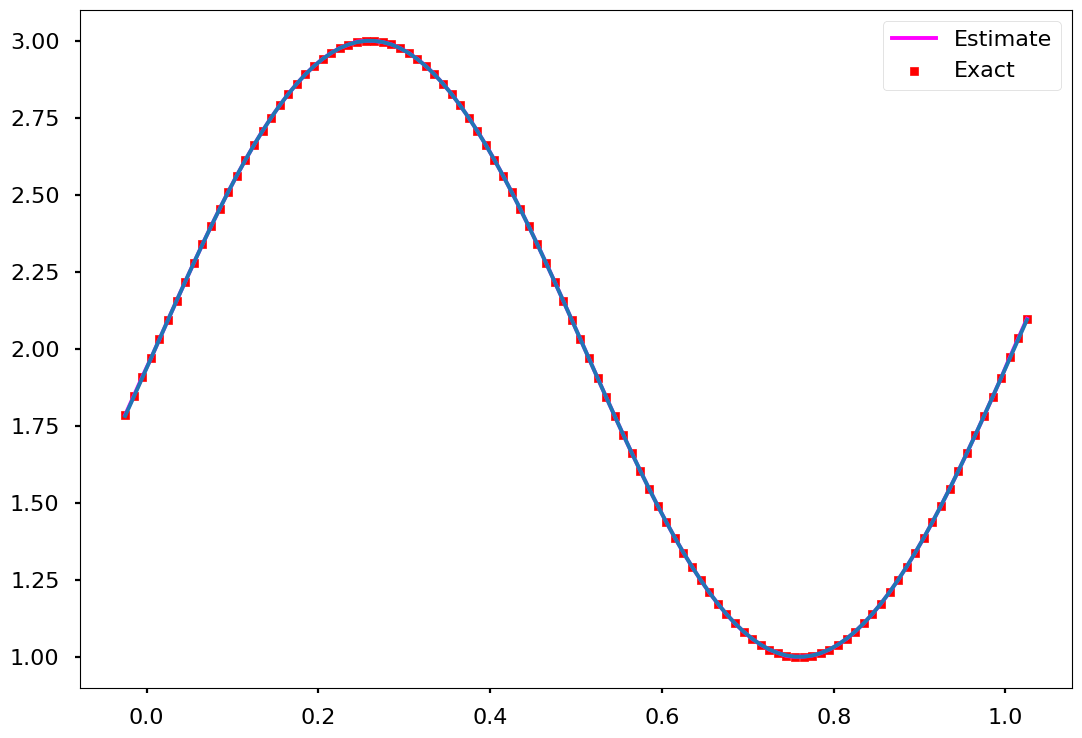

In [ ]:
cf = CFDSolverStructured.main()

In [ ]:
time_dt

[0.0011829182301264654,
 0.0011829728986542075,
 0.0011830155878479493,
 0.0011830475374429226,
 0.0011830695843321466,
 0.00118308224679736,
 0.00118308577834445,
 0.001183080199740757,
 0.000535727936713741]

In [ ]:
sum(time_dt)

0.01

# 2-Dimension
---

## Cell

In [ ]:
class Cell2D:
    def __init__(self):
        self.u =  np.array([[0.0, 0.0, 0.0, 0.0]] * (Config2D.NUM_RK_STEPS + 1))
        self.uwest = np.array([0.0, 0.0, 0.0, 0.0])
        self.uEast = np.array([0.0, 0.0, 0.0, 0.0])
        self.uNorth = np.array([0.0, 0.0, 0.0, 0.0])
        self.uSouth = np.array([0.0, 0.0, 0.0, 0.0])
        self.cx = 0.0
        self.dx = 0.0
        self.cy = 0.0
        self.dy = 0.0
        self.totalFlux = np.array([0.0, 0.0, 0.0, 0.0])

## Ghost Cells

In [ ]:
class GhostCellUpdater2D:
    @staticmethod
    def updateGhostCells(cells, rkStep):
        for j in range(len(cells[0])):
            for ghostCell in range(Config2D.NUM_GHOST_CELLS):
                cells[ghostCell][j].u[rkStep] = cells[Config2D.NUM_X_CELLS + ghostCell][j].u[rkStep]
                cells[Config2D.NUM_X_CELLS + Config2D.NUM_GHOST_CELLS + ghostCell][j].u[rkStep] = cells[Config2D.NUM_GHOST_CELLS + ghostCell][j].u[rkStep]

        for i in range(len(cells)):
            for ghostCell in range(Config2D.NUM_GHOST_CELLS):
                cells[i][ghostCell].u[rkStep] = cells[i][Config2D.NUM_Y_CELLS + ghostCell].u[rkStep]
                cells[i][Config2D.NUM_Y_CELLS + Config2D.NUM_GHOST_CELLS + ghostCell].u[rkStep] = cells[i][Config2D.NUM_GHOST_CELLS + ghostCell].u[rkStep]

## Config

In [ ]:
class Config2D:
    NUM_X_CELLS = 80
    NUM_Y_CELLS = 60
    NUM_GHOST_CELLS = 4
    NUM_RK_STEPS = 1       # Can be 1,2,3
    STOPPING_TIME = 0.01
    MAX_TIME_ITER = 100
    MIN_X = -0.5          # -1.0
    MAX_X = 0.5
    MIN_Y = -0.5           #-1.0
    MAX_Y = 0.5
    ADVECTION_VEL_X = 1.0
    ADVECTION_VEL_Y = 1.0
    COURANT_NUM = 0.5
    RECONST_TYPE = ReconstructionTypes.FIRST_ORDER
    gamma = 1.4

## Reconstruct Variables

In [ ]:
class VariableReconstructor2D:
    @staticmethod
    def reconstructVariables(cells, rkStep):
        reconst_type = Config2D.RECONST_TYPE

        if reconst_type == ReconstructionTypes.FIRST_ORDER:
            for i in range(Config2D.NUM_GHOST_CELLS - 1, Config2D.NUM_X_CELLS + Config2D.NUM_GHOST_CELLS + 1):
                for j in range(Config2D.NUM_GHOST_CELLS - 1, Config2D.NUM_Y_CELLS + Config2D.NUM_GHOST_CELLS + 1):
                    cells[i][j].uWest = cells[i][j].u[rkStep]
                    cells[i][j].uEast = cells[i][j].u[rkStep]
                    cells[i][j].uSouth = cells[i][j].u[rkStep]
                    cells[i][j].uNorth = cells[i][j].u[rkStep]


        #####################################################################################################
        ## Can be Seen Later - Not needed

        # elif reconst_type == ReconstructionTypes.BEAM_WARMING:
        #   for i in range(Config.NUM_GHOST_CELLS - 1, Config.NUM_X_CELLS + Config.NUM_GHOST_CELLS + 1):
        #       du_dx = (cells[i].u[rkStep] - cells[i - 1].u[rkStep]) / cells[i].dx
        #       cells[i].uWest = cells[i].u[rkStep] - du_dx * cells[i].dx / 2.0
        #       cells[i].uEast = cells[i].u[rkStep] + du_dx * cells[i].dx / 2.0

        # elif reconst_type == ReconstructionTypes.LAX_WENDROFF:
        #   for i in range(Config.NUM_GHOST_CELLS - 1, Config.NUM_X_CELLS + Config.NUM_GHOST_CELLS + 1):
        #       du_dx = (cells[i+1].u[rkStep] - cells[i].u[rkStep]) / cells[i].dx
        #       cells[i].uWest = cells[i].u[rkStep] - du_dx * cells[i].dx / 2.0
        #       cells[i].uEast = cells[i].u[rkStep] + du_dx * cells[i].dx / 2.0

        # elif reconst_type == ReconstructionTypes.FROMM:
        #   for i in range(Config.NUM_GHOST_CELLS - 1, Config.NUM_X_CELLS + Config.NUM_GHOST_CELLS + 1):
        #       du_dx = (cells[i+1].u[rkStep] - cells[i-1].u[rkStep]) / 2.0 / cells[i].dx
        #       cells[i].uWest = cells[i].u[rkStep] - du_dx * cells[i].dx / 2.0
        #       cells[i].uEast = cells[i].u[rkStep] + du_dx * cells[i].dx / 2.0

        elif reconst_type == ReconstructionTypes.LIMITED_LM:
          for i in range(Config2D.NUM_GHOST_CELLS - 1, Config2D.NUM_X_CELLS + Config2D.NUM_GHOST_CELLS + 1):
            for j in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_Y_CELLS+Config2D.NUM_GHOST_CELLS,1):
              r_x = (cells[i][j].u[rkStep] - cells[i-1][j].u[rkStep]) / (cells[i+1][j].u[rkStep] - cells[i][j].u[rkStep] + 0.000001)
              r_x = max(0, r_x)

              r_y = (cells[i][j].u[rkStep] - cells[i][j-1].u[rkStep]) / (cells[i][j+1].u[rkStep] - cells[i][j].u[rkStep] + 0.000001)
              r_y = max(0, r_y)
              # Alba Limiter
              phi_x = (r_x * r_x + r_x) / (r_x * r_x + 1.0)
              phi_y = (r_y * r_y + r_y) / (r_y * r_y + 1.0)
              du_dx = (cells[i+1][j].u[rkStep] - cells[i][j].u[rkStep]) / cells[i][j].dx
              du_dy = (cells[i][j+1].u[rkStep] - cells[i][j].u[rkStep]) / cells[i][j].dy

              cells[i][j].uWest = cells[i][j].u[rkStep] - phi_x * du_dx * cells[i][j].dx / 2.0
              cells[i][j].uEast = cells[i][j].u[rkStep] + phi_x * du_dx * cells[i][j].dx / 2.0

              cells[i][j].uSouth = cells[i][j].u[rkStep] - phi_y * du_dy * cells[i][j].dy / 2.0
              cells[i][j].uNorth = cells[i][j].u[rkStep] + phi_y * du_dy * cells[i][j].dy / 2.0


## Variable Copier

In [ ]:
class VariableCopier2D:
    def CopyToZerothRKStep(cells):
        for i in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_X_CELLS + Config2D.NUM_GHOST_CELLS, 1):
            for j in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_Y_CELLS + Config2D.NUM_GHOST_CELLS, 1):
                cells[i][j].u[0] = cells[i][j].u[Config2D.NUM_RK_STEPS]

## Time Step Calculator
Will have to update this - Fixed

In [ ]:
def calculatePressure2D(cell):
    rho = cell.u[0][0]
    S = cell.u[0][3] / rho
    Cv = 1/(Config2D.gamma - 1)
    return (rho ** Config2D.gamma) * np.exp(S/Cv)

In [ ]:
class TimeStepCalculator2D:
    @staticmethod
    def getTimeStep(cells):
        # dt1 = cells[0][0].dx / abs(Config2D.ADVECTION_VEL_X)
        # dt2 = cells[0][0].dy / abs(Config2D.ADVECTION_VEL_Y)
        # dt = 1.0 / (1.0 / dt1 + 1.0 / dt2)          # Optimal dt in this case
        # return dt * Config2D.COURANT_NUM
        press = np.array([[calculatePressure2D(cell) for cell in cell_arr] for cell_arr in cells])
        rho = np.array([[cell.u[0][0] for cell in cell_arr] for cell_arr in cells])
        soundSpeed = np.sqrt(Config2D.gamma * press / (rho+1e-5))
        v = np.array([[np.sqrt(cell.u[0][1] ** 2 + cell.u[0][2] ** 2) for cell in cell_arr] for cell_arr in cells])

        return [Config.COURANT_NUM * cells[0][0].dx * ((np.abs(v) + soundSpeed).max()), (np.abs(v) + soundSpeed).max()]


## Time Integration

In [ ]:
class TimeIntegration2D:
    @staticmethod
    def updateCellAverage(cells, rkStep, dt):
        area = cells[0][0].dx * cells[0][0].dy

        if(Config2D.NUM_RK_STEPS == 1):
            for i in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_X_CELLS+Config2D.NUM_GHOST_CELLS,1):
                for j in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_Y_CELLS+Config2D.NUM_GHOST_CELLS,1):
                    cells[i][j].u[rkStep+1] = cells[i][j].u[rkStep] + dt / area * cells[i][j].totalFlux

        elif(Config.NUM_RK_STEPS == 2):
            for i in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_X_CELLS+Config2D.NUM_GHOST_CELLS,1):
                for j in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_Y_CELLS+Config2D.NUM_GHOST_CELLS,1):
                    if(rkStep == 0):
                        cells[i][j].u[rkStep+1] = cells[i][j].u[rkStep] + dt / area * cells[i][j].totalFlux
                    elif(rkStep == 1):
                        cells[i][j].u[rkStep+1] = 0.5 * {cells[i][j].u[rkStep-1] + cells[i][j].u[rkStep] + dt/area * cells[i][j].totalFlux}

        elif(Config.NUM_RK_STEPS == 3):
            for i in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_X_CELLS+Config2D.NUM_GHOST_CELLS,1):
                for j in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_Y_CELLS+Config2D.NUM_GHOST_CELLS,1):
                    if(rkStep == 0):
                        cells[i][j].u[rkStep+1] = cells[i][j].u[rkStep] + dt / area * cells[i][j].totalFlux
                    elif(rkStep == 1):
                        cells[i][j].u[rkStep+1] = 0.75 * cells[i][j].u[rkStep-1] + 0.25 * cells[i][j].u[rkStep] + 0.25 * dt/area * cells[i][j].totalFlux
                    elif(rkStep == 2):
                        cells[i][j].u[rkStep+1] = 0.33 * cells[i][j].u[rkStep-2] + 0.67 * cells[i][j].u[rkStep] + 0.67 * dt/area * cells[i][j].totalFlux

## Flux
Need Changes

In [ ]:
class Flux2D:
    @staticmethod
    def calculateFlux(cells, rkStep):
        for i in range(len(cells)):
            for j in range(len(cells[0])):
                cells[i].totalFlux = [0.0, 0.0, 0.0, 0.0]

        dx = cells[0][0].dx
        dy = cells[0][0].dy
        # Flux Calculation for all vertical edges
        for j in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_Y_CELLS+Config2D.NUM_GHOST_CELLS,1):
            for verticalinterfaceIndex in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_X_CELLS+Config2D.NUM_GHOST_CELLS, 1):
                # leftValue = cells[verticalinterfaceIndex-1][j].uEast
                # rightValue = cells[verticalinterfaceIndex-1][j].uWest

                # # Flux calculation according to the scheme
                # flux = 0.5 * Config2D.ADVECTION_VEL_X * (leftValue + rightValue) - 0.5 * abs(Config2D.ADVECTION_VEL_X) * (rightValue - leftValue)
                # flux *= dy
                # cells[verticalinterfaceIndex-1][j].totalFlux -= flux
                # cells[verticalinterfaceIndex][j].totalFlux += flux;

                # left
                left_m1 = cells[verticalinterfaceIndex-1][j].uEast[0]
                left_m2 = cells[verticalinterfaceIndex-1][j].uEast[1]
                left_m3 = cells[verticalinterfaceIndex-1][j].uEast[2]
                left_m4 = cells[verticalinterfaceIndex-1][j].uEast[3]

                left_c1, left_c2, left_c3, left_c4 = left_m3, 0.0, 0.0, 0.0
                left_p = calculatePressure2D(cells[verticalinterfaceIndex-1][j])

                left_c2 += left_p
                # if(not(math.isnan((left_m2 ** 2) / left_m1))):
                #     left_c2 += ((left_m2 ** 2) / left_m1)

                if(not(math.isnan((left_m3 ** 2) / left_m1))):
                    left_c2 += ((left_m3 ** 2) / left_m1)

                if(not(math.isnan(left_m3 / left_m1))):
                    left_c3 += left_m2 * left_m3 / left_m1

                # if(not(math.isnan(left_m2 * left_m4 / left_m1))):
                #     left_c4 += (left_m2 * left_m4 / left_m1)

                if(not(math.isnan(left_m3 * left_m4 / left_m1))):
                    left_c4 += (left_m3 * left_m4 / left_m1)
                leftValue = np.array([left_c1, left_c2, left_c3, left_c4])

                # Right
                right_m1 = cells[verticalinterfaceIndex][j].uWest[0]
                right_m2 = cells[verticalinterfaceIndex][j].uWest[1]
                right_m3 = cells[verticalinterfaceIndex][j].uWest[2]
                right_m4 = cells[verticalinterfaceIndex][j].uWest[3]

                right_c1, right_c2, right_c3, right_c4 = right_m3, 0.0, 0.0, 0.0
                right_p =calculatePressure2D(cells[verticalinterfaceIndex][j])

                right_c2 += right_p
                # if(not(math.isnan((right_m2 ** 2) / right_m1))):
                #     right_c2 += ((right_m2 ** 2) / right_m1)

                if(not(math.isnan((right_m3 ** 2) / right_m1))):
                    right_c2 += ((right_m3 ** 2) / right_m1)

                if(not(math.isnan(right_m3 / right_m1))):
                    right_c3 += right_m2 * right_m3 / right_m1

                # if(not(math.isnan(right_m2 * right_m4 / right_m1))):
                #     right_c4 += (right_m2 * right_m4 / right_m1)

                if(not(math.isnan(right_m3 * right_m4 / right_m1))):
                    right_c4 += (right_m3 * right_m4 / right_m1)
                rightValue = np.array([right_c1, right_c2, right_c3, right_c4])

                flux = 0.5 * (rightValue + leftValue)
                cells[verticalinterfaceIndex-1][j].totalFlux -= flux
                cells[verticalinterfaceIndex][j].totalFlux += flux;

        # Flux Calculation for all horizontal edges
        for i in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_X_CELLS+Config2D.NUM_GHOST_CELLS,1):
            for horizontalinterfaceIndex in range(Config2D.NUM_GHOST_CELLS, Config2D.NUM_GHOST_CELLS+Config2D.NUM_Y_CELLS+1, 1):
                # leftValue = cells[i][verticalinterfaceIndex-1].uNorth
                # rightValue = cells[i][verticalinterfaceIndex-1].uSouth

                # # Flux calculation according to the scheme
                # flux = 0.5 * Config2D.ADVECTION_VEL_Y * (leftValue + rightValue) - 0.5 * abs(Config2D.ADVECTION_VEL_Y) * (rightValue - leftValue)
                # flux *= dx
                # cells[i][verticalinterfaceIndex-1].totalFlux -= flux
                # cells[i][verticalinterfaceIndex].totalFlux += flux;

                # left
                left_m1 = cells[i][horizontalinterfaceIndex-1].uNorth[0]
                left_m2 = cells[i][horizontalinterfaceIndex-1].uNorth[1]
                left_m3 = cells[i][horizontalinterfaceIndex-1].uNorth[2]
                left_m4 = cells[i][horizontalinterfaceIndex-1].uNorth[3]

                left_c1, left_c2, left_c3, left_c4 = left_m2, 0.0, 0.0, 0.0
                left_p = calculatePressure(cells[i][horizontalinterfaceIndex-1])

                left_c2 += left_p
                if(not(math.isnan((left_m2 ** 2) / left_m1))):
                    left_c2 += ((left_m2 ** 2) / left_m1)

                # if(not(math.isnan((left_m3 ** 2) / left_m1))):
                #     left_c2 += ((left_m3 ** 2) / left_m1)

                if(not(math.isnan(left_m3 / left_m1))):
                    left_c3 += left_m2 * left_m3 / left_m1

                if(not(math.isnan(left_m2 * left_m4 / left_m1))):
                    left_c4 += (left_m2 * left_m4 / left_m1)

                # if(not(math.isnan(left_m3 * left_m4 / left_m1))):
                #     left_c4 += (left_m3 * left_m4 / left_m1)
                leftValue = np.array([left_c1, left_c2, left_c3, left_c4])

                # Right
                right_m1 = cells[i][horizontalinterfaceIndex].uSouth[0]
                right_m2 = cells[i][horizontalinterfaceIndex].uSouth[1]
                right_m3 = cells[i][horizontalinterfaceIndex].uSouth[2]
                right_m4 = cells[i][horizontalinterfaceIndex].uSouth[3]

                right_c1, right_c2, right_c3, right_c4 = right_m2, 0.0, 0.0, 0.0
                right_p = calculatePressure(cells[i][horizontalinterfaceIndex])

                right_c2 += right_p
                if(not(math.isnan((right_m2 ** 2) / right_m1))):
                    right_c2 += ((right_m2 ** 2) / right_m1)

                # if(not(math.isnan((right_m3 ** 2) / right_m1))):
                #     right_c2 += ((right_m3 ** 2) / right_m1)

                if(not(math.isnan(right_m3 / right_m1))):
                    right_c3 += right_m2 * right_m3 / right_m1

                if(not(math.isnan(right_m2 * right_m4 / right_m1))):
                    right_c4 += (right_m2 * right_m4 / right_m1)

                # if(not(math.isnan(right_m3 * right_m4 / right_m1))):
                #     right_c4 += (right_m3 * right_m4 / right_m1)
                rightValue = np.array([right_c1, right_c2, right_c3, right_c4])

                flux = 0.5 * (rightValue + leftValue)
                cells[i][horizontalinterfaceIndex-1].totalFlux -= flux
                cells[i][horizontalinterfaceIndex].totalFlux += flux;

## Solution Initializer \& Writer

In [ ]:
import math
class SolutionInitializer2D:
    @staticmethod
    def initializeSolution(cells):
        rkStep = 0
        for cellrow in cells:
          for cell in cellrow:
            # if(-0.25 < cell.cx < 0.25 and -0.25 < cell.dy < 0.25):
            #     cell.u[rkStep] = 1.0
            # else:
            #     cell.u[rkStep] = 0.0
            if(cell.cx > 0 and cell.cy > 0):
                cell.u[rkStep] = [1.0, 0.75, -0.5, 0.0]

            elif(cell.cx < 0 and cell.cy > 0):
                cell.u[rkStep] = [2.0, 1.5, 1.0, 2.0 * np.log(1/(2.0**Config2D.gamma))/(Config2D.gamma-1)]

            elif(cell.cx < 0 and cell.cy < 0):
                cell.u[rkStep] = [1.0, -0.75, 0.5, 0.0]

            else:
                cell.u[rkStep] = [3.0, -2.25, -1.5, 3.0 * np.log(1/(3.0**Config2D.gamma))/(Config2D.gamma-1)]

            # cell.u[rkStep] = math.sin(math.pi * cell.cx)


## CFD Solver
Need Changes

In [ ]:
class CFDSolverStructured2D:
    @staticmethod
    def main():
        cells = [[Cell2D() for _ in range(Config2D.NUM_Y_CELLS + 2 * Config2D.NUM_GHOST_CELLS)] for j in range(Config2D.NUM_X_CELLS + 2 * Config2D.NUM_GHOST_CELLS)]

        dx = (Config2D.MAX_X - Config2D.MIN_X) / Config2D.NUM_X_CELLS
        dy = (Config2D.MAX_Y - Config2D.MIN_Y) / Config2D.NUM_Y_CELLS
        for i in range(len(cells)):
            for j in range(len(cells[0])):
                cells[i][j] = Cell2D()
                cells[i][j].dx = dx
                cells[i][j].cx = Config2D.MIN_X + dx * (i + 0.5 - Config2D.NUM_GHOST_CELLS) #/ (2 * Config2D.NUM_GHOST_CELLS)
                cells[i][j].dy = dy
                cells[i][j].cy = Config2D.MIN_Y + dy * (j + 0.5 - Config2D.NUM_GHOST_CELLS) # / (2 * Config2D.NUM_GHOST_CELLS)

        arr_cx = [[cell.cx for cell in cell_arr[Config2D.NUM_GHOST_CELLS:-Config2D.NUM_GHOST_CELLS]] for cell_arr in cells[Config2D.NUM_GHOST_CELLS:-Config2D.NUM_GHOST_CELLS]]

        SolutionInitializer2D.initializeSolution(cells)
        data = [[cell.u[0] for cell in cell_arr] for cell_arr in cells]
        arr_data = [[cell.u[0][0] for cell in cell_arr[Config2D.NUM_GHOST_CELLS:-Config2D.NUM_GHOST_CELLS]] for cell_arr in cells[Config2D.NUM_GHOST_CELLS:-Config2D.NUM_GHOST_CELLS]]
        x = np.linspace(-0.5, 0.5, len(arr_data))
        y = np.linspace(-0.5, 0.5, len(arr_data[0]))
        X, Y = np.meshgrid(x, y)
        # fig = plt.figure(figsize = (8,6))
        # ax = plt.axes(projection='3d')
        # ax.scatter3D(X, Y, arr_data,color = 'black', s =1)
        # # ax.plot3D(X, Y, data,color = 'black', s =1)
        # ax.grid()
        # ax.plot3D(x,y,data)
        # plt.show()
        arr_data = np.array(arr_data)
        time = 0.0
        #   SolutionFileWriter2D.writeSolutionFile(cells, time)
        lastTimeStep = False

        for timeiter in range(Config2D.MAX_TIME_ITER):
            arr = TimeStepCalculator2D.getTimeStep(cells)
            dt = arr[0]
            if(time + dt > Config2D.STOPPING_TIME):
                dt = Config2D.STOPPING_TIME - time
                lastTimeStep = True

            for rkStep in range(Config2D.NUM_RK_STEPS):
                GhostCellUpdater2D.updateGhostCells(cells, rkStep)
                VariableReconstructor2D.reconstructVariables(cells, rkStep)
                Flux2D.calculateFlux
                TimeIntegration2D.updateCellAverage(cells, rkStep, dt)

            VariableCopier2D.CopyToZerothRKStep(cells)
            time += dt
            if(lastTimeStep):
                break
        data = [[cell.u[0][0] for cell in cell_arr[Config2D.NUM_GHOST_CELLS:-Config2D.NUM_GHOST_CELLS]] for cell_arr in cells[Config2D.NUM_GHOST_CELLS:-Config2D.NUM_GHOST_CELLS]]

        # print(data.shape)
        x = np.linspace(-0.5, 0.5, len(data))
        y = np.linspace(-0.5, 0.5, len(data[0]))
        X, Y = np.meshgrid(x, y)
        plt.imshow(np.array(data), cmap = 'hot')
        plt.show()
        # ax.plot3D(x,y,data)
        # plt.show()
        # data = np.array(data)
        # print(np.unique(data))

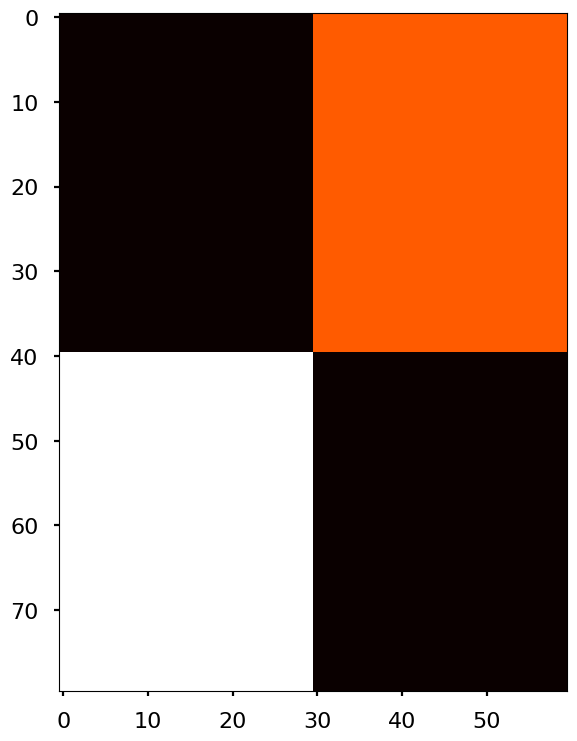

In [ ]:
cf = CFDSolverStructured2D.main()